# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
# Run once to install libraries
# !pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [2]:
import os, shutil
import time
import uuid
import cv2

In [3]:
os.mkdir('data')

In [4]:
os.mkdir('data\images')

In [5]:
os.mkdir('data\labels')

In [6]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 20

In [7]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [8]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\huyho\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [9]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.__version__


'2.9.1'

In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### 2.3 Load Image into TF Data Pipeline

In [14]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [15]:
images.as_numpy_iterator().next()

b'data\\images\\f811ba27-05b1-11ed-84fb-7085c27b524a.jpg'

In [16]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [17]:
images = images.map(load_image)

In [18]:
images.as_numpy_iterator().next()

array([[[132, 149, 141],
        [133, 150, 142],
        [134, 151, 143],
        ...,
        [ 91,  88,  81],
        [ 89,  86,  77],
        [ 85,  85,  75]],

       [[132, 149, 141],
        [133, 150, 142],
        [134, 151, 143],
        ...,
        [ 92,  87,  81],
        [ 90,  87,  80],
        [ 90,  87,  80]],

       [[133, 150, 142],
        [133, 150, 142],
        [134, 151, 143],
        ...,
        [ 95,  87,  84],
        [ 93,  88,  84],
        [ 94,  89,  85]],

       ...,

       [[113, 193, 202],
        [130, 208, 218],
        [137, 209, 221],
        ...,
        [123, 106, 114],
        [122, 105, 113],
        [122, 105, 113]],

       [[119, 196, 204],
        [130, 204, 213],
        [139, 207, 218],
        ...,
        [125, 105, 114],
        [124, 104, 113],
        [124, 104, 113]],

       [[136, 211, 217],
        [134, 207, 214],
        [144, 208, 220],
        ...,
        [126, 105, 114],
        [126, 105, 114],
        [125, 104, 113]]

In [19]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [20]:
image_generator = images.batch(4).as_numpy_iterator()

In [21]:
plot_images = image_generator.next()

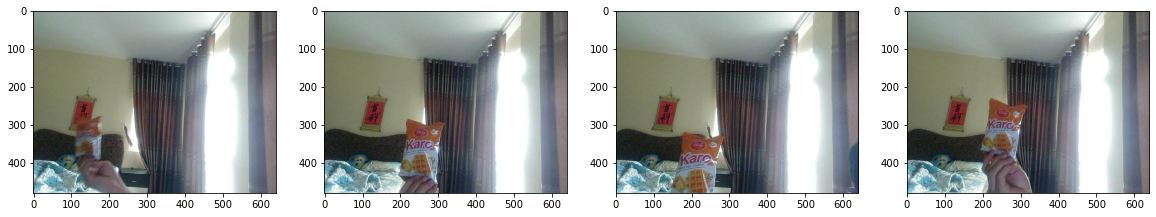

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [32]:
number_images = len(os.listdir(os.path.join('data', 'images')))
number_images

40

In [33]:
train_images = int(number_images*(0.70))
print(train_images)
valid_images = int(number_images*(0.15))
print(valid_images)
test_images = number_images - train_images - valid_images
print(test_images)



28
6
6


In [34]:
# Don't rerun!
# Split files to new directories
files = os.listdir(os.path.join('data', 'images'))
os.mkdir('data\\train')
os.mkdir('data\\train\\images')
os.mkdir('data\\train\\labels')
x = 0
for f in files:
    shutil.copy(os.path.join('data','images', f), 'data\\train\\images')
    x += 1
    if (x==train_images): break
    
files = os.listdir(os.path.join('data', 'images'))   
os.mkdir('data\\val')
os.mkdir('data\\val\\images')
os.mkdir('data\\val\\labels')
x = 0
for f in files:
    shutil.copy(os.path.join('data','images', f), 'data\\val\\images')
    x += 1
    if (x==valid_images): break
    
files = os.listdir(os.path.join('data', 'images'))
os.mkdir('data\\test')
os.mkdir('data\\test\\images')
os.mkdir('data\\test\\labels')
x = 0
for f in files:
    shutil.copy(os.path.join('data','images', f), 'data\\test\\images')
    x += 1
    if (x==test_images): break

### 3.2 Move the Matching Labels

In [35]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            shutil.copy(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [36]:
import albumentations as alb

In [37]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [38]:
# Repalce filename
anno_image = 'bb8c1800-05ab-11ed-aa2c-7085c27b524a'

In [39]:
img = cv2.imread(os.path.join('data','train', 'images', anno_image+'.jpg'))

In [40]:
with open(os.path.join('data', 'train', 'labels', anno_image+'.json'), 'r') as f:
    label = json.load(f)

In [41]:
label['shapes'][0]['points']

[[204.9009900990099, 177.7128712871287],
 [335.5940594059406, 355.43564356435644]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [42]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [43]:
coords

[204.9009900990099, 177.7128712871287, 335.5940594059406, 355.43564356435644]

In [44]:
coords = list(np.divide(coords, [640,480,640,480]))

In [45]:
coords

[0.320157797029703,
 0.37023514851485145,
 0.5243657178217822,
 0.7404909240924092]

### 4.4 Apply Augmentations and View Results

In [46]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Karo'])

In [47]:
augmented['bboxes'][0][2:]

(0.7802200220022002, 0.6428602860286029)

In [48]:
augmented['bboxes']

[(0.4897909790979098,
  0.24792079207920792,
  0.7802200220022002,
  0.6428602860286029)]

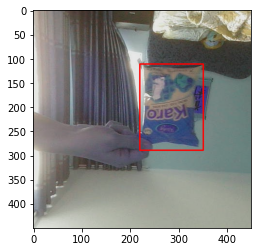

In [49]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [50]:
# Create directory

os.mkdir('aug_data')
for partition in ['train','test','val']: 
    os.mkdir(os.path.join('aug_data', partition))
    os.mkdir(os.path.join('aug_data', partition, 'images'))
    os.mkdir(os.path.join('aug_data', partition, 'labels'))

In [51]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [52]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [53]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [54]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [55]:
train_images.as_numpy_iterator().next()

array([[[0.77947307, 0.8971201 , 0.91672796],
        [0.80245095, 0.8893995 , 0.90116423],
        [0.9012255 , 0.9355392 , 0.94191176],
        ...,
        [0.853125  , 0.8810662 , 0.9026348 ],
        [0.98204654, 0.99871325, 0.9952819 ],
        [0.99313724, 1.        , 1.        ]],

       [[0.9288603 , 0.9957108 , 0.9957108 ],
        [0.9384191 , 0.97083336, 0.9580882 ],
        [0.9808211 , 0.99871325, 0.98333335],
        ...,
        [0.85539216, 0.8833333 , 0.904902  ],
        [0.9754902 , 0.99215686, 0.9887255 ],
        [0.99313724, 1.        , 1.        ]],

       [[0.89123774, 0.9607843 , 0.95998776],
        [0.98492646, 1.        , 0.9980392 ],
        [0.9956495 , 0.99914217, 0.9902574 ],
        ...,
        [0.86764705, 0.8955882 , 0.9171569 ],
        [0.9832721 , 0.9999387 , 0.99650735],
        [0.99313724, 1.        , 1.        ]],

       ...,

       [[0.6897059 , 0.74852943, 0.7289216 ],
        [0.6901961 , 0.7490196 , 0.7294118 ],
        [0.68284315, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [56]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [57]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [58]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [59]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [60]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [61]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1680, 1680, 360, 360, 360, 360)

### 7.2 Create Final Datasets (Images/Labels)

In [62]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [63]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [64]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [65]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4692, 0.219 , 0.7275, 0.5723],
        [0.2612, 0.5737, 0.5195, 0.9775],
        [0.1608, 0.3364, 0.5723, 0.9194],
        [0.    , 0.    , 0.    , 0.    ],
        [0.275 , 0.1898, 0.7085, 0.7925],
        [0.456 , 0.3186, 0.797 , 0.7607],
        [0.4473, 0.0609, 0.875 , 0.6387],
        [0.1229, 0.0894, 0.534 , 0.6724]], dtype=float16))

### 7.3 View Images and Annotations

In [66]:
data_samples = train.as_numpy_iterator()

In [67]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


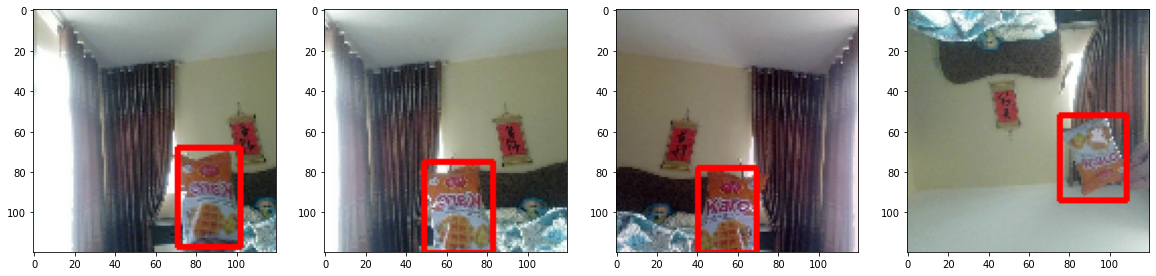

In [68]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [69]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [70]:
vgg = VGG16(include_top=False)

In [71]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [72]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [73]:
facetracker = build_model()

In [74]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [75]:
X, y = train.as_numpy_iterator().next()

In [76]:
X.shape

(8, 120, 120, 3)

In [77]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 2s 2s/step


In [78]:
classes, coords

(array([[0.3948216 ],
        [0.39760932],
        [0.37623495],
        [0.39609882],
        [0.42012003],
        [0.43144634],
        [0.4155429 ],
        [0.46326417]], dtype=float32),
 array([[0.3589208 , 0.5159831 , 0.4047884 , 0.54784197],
        [0.32820255, 0.5829092 , 0.30233377, 0.56621087],
        [0.3140007 , 0.56269217, 0.2998904 , 0.5440621 ],
        [0.38081306, 0.62957186, 0.4089225 , 0.5428219 ],
        [0.31989926, 0.5194885 , 0.4508772 , 0.5210783 ],
        [0.3269587 , 0.5376544 , 0.37853548, 0.5468904 ],
        [0.32987046, 0.5869406 , 0.31482467, 0.5992193 ],
        [0.3471967 , 0.58795786, 0.3809209 , 0.57371897]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [79]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [80]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [81]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [82]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [83]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.895452>

In [84]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.80241287>

In [85]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.895452>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [86]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [87]:
model = FaceTracker(facetracker)

In [88]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [89]:
logdir='logs'

In [90]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [91]:
hist = model.fit(train, epochs=6, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/6
210/210 [==============================] - 26s 99ms/step - total_loss: 0.4191 - class_loss: 0.0854 - regress_loss: 0.3764 - val_total_loss: 0.1485 - val_class_loss: 0.0333 - val_regress_loss: 0.1319
Epoch 2/6
210/210 [==============================] - 22s 93ms/step - total_loss: 0.0865 - class_loss: 0.0170 - regress_loss: 0.0780 - val_total_loss: 0.0683 - val_class_loss: 0.0115 - val_regress_loss: 0.0626
Epoch 3/6
210/210 [==============================] - 22s 93ms/step - total_loss: 0.0500 - class_loss: 0.0078 - regress_loss: 0.0461 - val_total_loss: 0.0330 - val_class_loss: 0.0030 - val_regress_loss: 0.0315
Epoch 4/6
210/210 [==============================] - 22s 93ms/step - total_loss: 0.0442 - class_loss: 0.0100 - regress_loss: 0.0392 - val_total_loss: 0.0161 - val_class_loss: 1.6854e-05 - val_regress_loss: 0.0161
Epoch 5/6
210/210 [==============================] - 22s 92ms/step - total_loss: 0.0204 - class_loss: 0.0020 - regress_loss: 0.0194 - val_total_loss: 0.0089 - v

### 10.3 Plot Performance

In [92]:
hist.history

{'total_loss': [0.05145708844065666,
  0.036776915192604065,
  0.04149497672915459,
  0.011132597923278809,
  0.005506995599716902,
  0.01732977107167244],
 'class_loss': [0.002330415416508913,
  0.00011503840505611151,
  0.0003189689596183598,
  7.587158324895427e-05,
  4.2335996113251895e-05,
  0.0018446739995852113],
 'regress_loss': [0.05029188096523285,
  0.03671939671039581,
  0.041335493326187134,
  0.011094662360846996,
  0.005485827568918467,
  0.01640743389725685],
 'val_total_loss': [0.14851237833499908,
  0.06833770126104355,
  0.03302057459950447,
  0.016149690374732018,
  0.008853983134031296,
  0.008127979934215546],
 'val_class_loss': [0.033255357295274734,
  0.011515888385474682,
  0.002976174931973219,
  1.6853575289133005e-05,
  4.592761251842603e-05,
  1.6927995602600276e-05],
 'val_regress_loss': [0.13188469409942627,
  0.06257975846529007,
  0.03153248876333237,
  0.016141263768076897,
  0.008831019513309002,
  0.00811951607465744]}

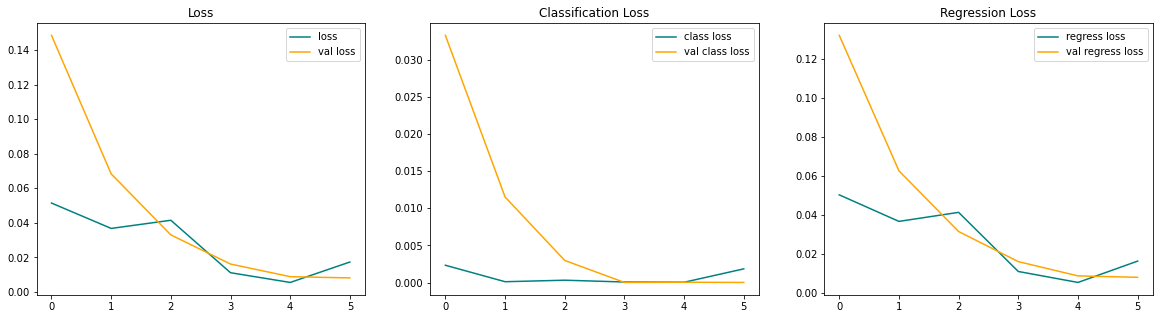

In [93]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [94]:
test_data = test.as_numpy_iterator()

In [95]:
test_sample = test_data.next()

In [96]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


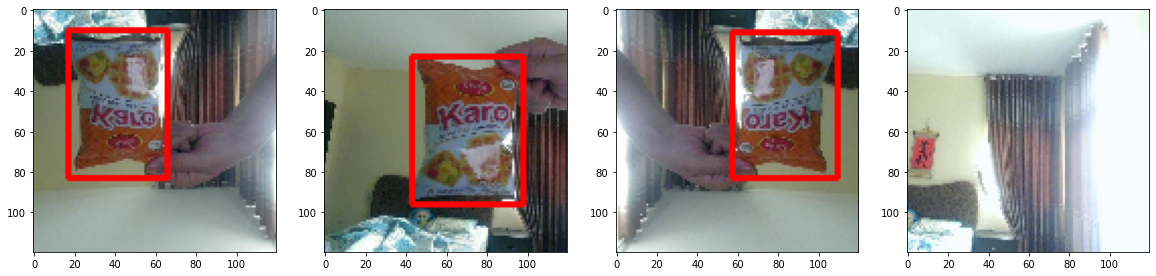

In [97]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [98]:
from tensorflow.keras.models import load_model

In [99]:
facetracker.save('facetracker.h5')

In [100]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [101]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    #frame = frame[0:1000, 0:1000,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Karo', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 21ms/step
